In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L2
import warnings
warnings.filterwarnings('ignore')

2023-11-17 09:10:31.800014: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 09:10:31.938606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 09:10:31.938633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 09:10:31.939510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 09:10:32.012853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 09:10:32.013840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
train_path = 'data/cats-dogs/train'
len(os.listdir(train_path))

25000

### Visualization Some pictures

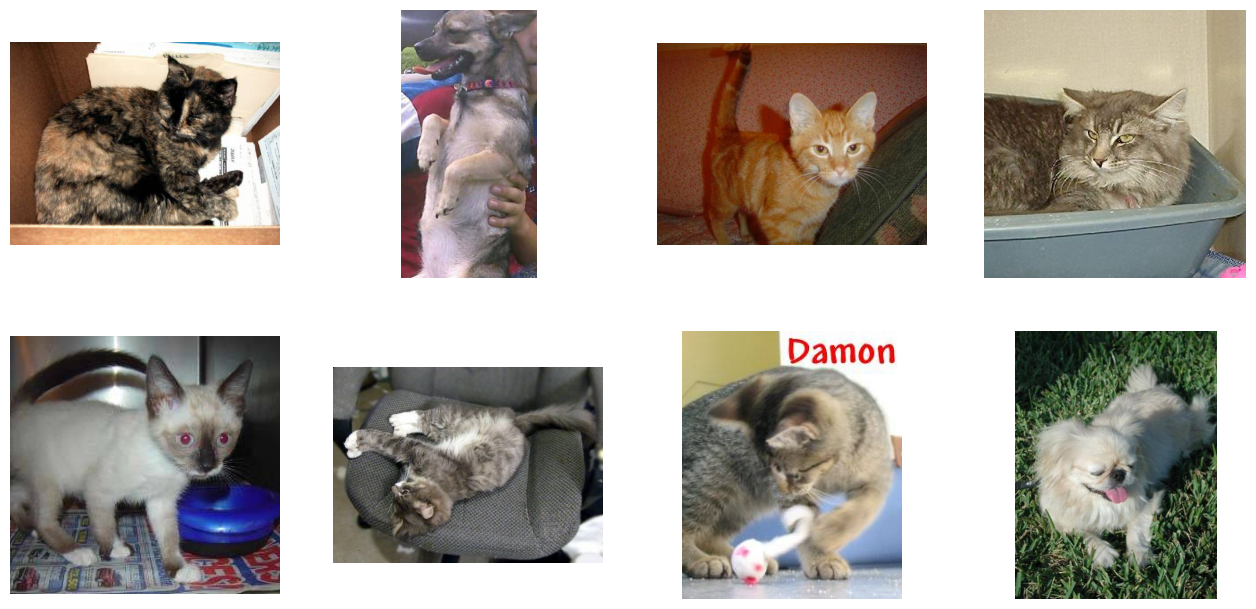

In [3]:
plt.figure(figsize=(16,16))
images = os.listdir(train_path)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(train_path, img)) 
    fig.imshow(img) 

In [4]:
os.listdir(train_path)[:20]

['dog.8659.jpg',
 'cat.4935.jpg',
 'cat.9291.jpg',
 'cat.10060.jpg',
 'dog.4013.jpg',
 'cat.140.jpg',
 'dog.4214.jpg',
 'dog.1732.jpg',
 'dog.2490.jpg',
 'dog.40.jpg',
 'dog.7974.jpg',
 'dog.2496.jpg',
 'cat.9960.jpg',
 'cat.2204.jpg',
 'cat.11976.jpg',
 'dog.2123.jpg',
 'dog.2865.jpg',
 'dog.9573.jpg',
 'cat.7511.jpg',
 'dog.5059.jpg']

### Organize the directories

In [5]:
# for dir in ['training', 'validation']:
#     path = os.path.join('data/cats-dogs' , dir)
#     os.mkdir(path)
#     for dir in ['cats', 'dogs']:
#         n_path = os.path.join(path , dir)
#         os.mkdir(n_path)

In [6]:
src_dir = train_path
cats_train_dir = 'data/cats-dogs/training/cats'
cats_valid_dir = 'data/cats-dogs/validation/cats'
dogs_train_dir = 'data/cats-dogs/training/dogs'
dogs_valid_dir = 'data/cats-dogs/validation/dogs'

cats = [img for img in os.listdir(src_dir) if img[:3] == 'cat']
dogs = [img for img in os.listdir(src_dir) if img[:3] == 'dog']

In [7]:
# Take 10% of training images for validation    
np.random.seed(100)
cats_valid_sample = random.sample(cats, int(0.1*len(cats))) 
dogs_valid_sample = random.sample(dogs, int(0.1*len(dogs)))

In [8]:
for img in os.listdir(src_dir):
    src_img = os.path.join(src_dir, img)
    if img[:3] == 'cat':
        if img in cats_valid_sample:
            dest_img = os.path.join(cats_valid_dir, img)
        else:
            dest_img = os.path.join(cats_train_dir, img)
    elif img[:3] == 'dog':
        if img in dogs_valid_sample:
            dest_img = os.path.join(dogs_valid_dir, img)
        else:
            dest_img = os.path.join(dogs_train_dir, img)
    if not os.path.exists(dest_img):
        shutil.copyfile(src_img, dest_img)

In [9]:
print('No. of ALL cats : ', len(cats))
print('No. of cats for training: ', len(os.listdir(cats_train_dir)))
print('No. of cats for validation: ', len(os.listdir(cats_valid_dir)))

print('\nNo. of ALL dogs : ', len(dogs))
print('No. of dogs for training: ', len(os.listdir(dogs_train_dir)))
print('No. of dogs for validation: ', len(os.listdir(dogs_valid_dir)))

No. of ALL cats :  12500
No. of cats for training:  12488
No. of cats for validation:  3378

No. of ALL dogs :  12500
No. of dogs for training:  12494
No. of dogs for validation:  3378


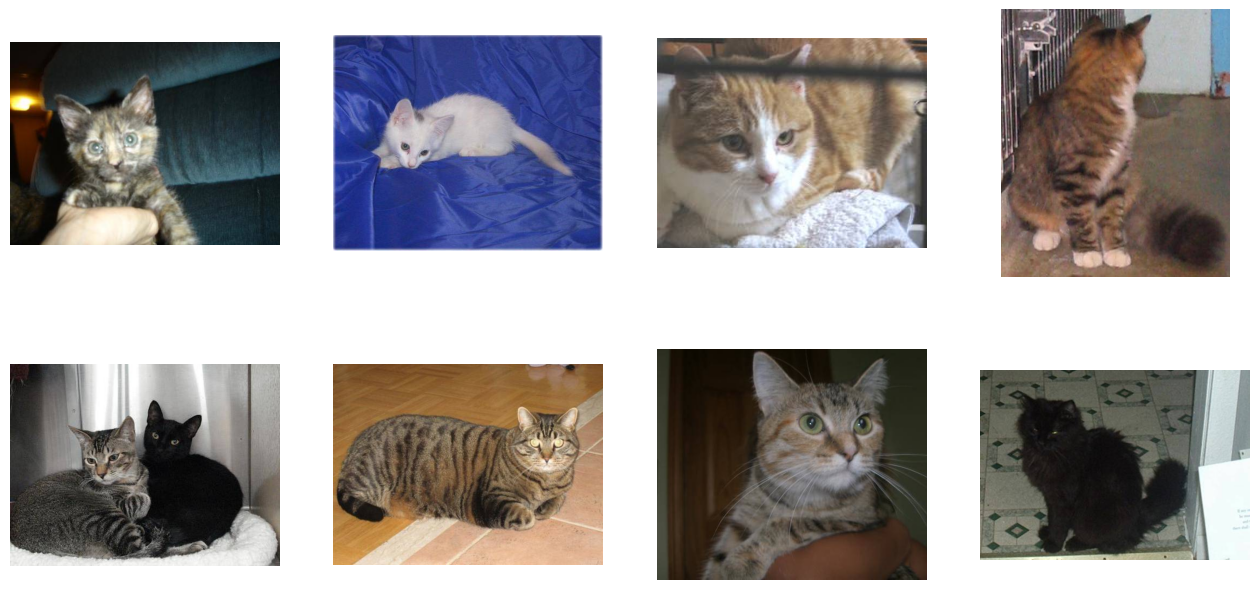

In [10]:
plt.figure(figsize=(16,16))

images = os.listdir(cats_train_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(cats_train_dir, img)) 
    fig.imshow(img) 

### Image Data Generator

In [11]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

In [12]:
train_dir = 'data/cats-dogs/training/'
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
valid_dir = 'data/cats-dogs/validation/'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 24982 images belonging to 2 classes.
Found 6756 images belonging to 2 classes.


In [13]:
print(valid_generator.class_indices)

{'cats': 0, 'dogs': 1}


### Modelling

In [14]:
# create model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

2023-11-17 09:10:46.011911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 09:10:46.104424: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
# Compile model 
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [16]:
# fit the model 
history = model.fit(train_generator, epochs=5, verbose=1, validation_data=valid_generator)

Epoch 1/5
781/781 [==============================] - 236s 301ms/step - loss: 0.5761 - accuracy: 0.6877 - val_loss: 0.4693 - val_accuracy: 0.7740
Epoch 2/5
781/781 [==============================] - 236s 303ms/step - loss: 0.4608 - accuracy: 0.7844 - val_loss: 0.4341 - val_accuracy: 0.7940
Epoch 3/5
781/781 [==============================] - 240s 307ms/step - loss: 0.4020 - accuracy: 0.8174 - val_loss: 0.3659 - val_accuracy: 0.8307
Epoch 4/5
781/781 [==============================] - 232s 296ms/step - loss: 0.3601 - accuracy: 0.8389 - val_loss: 0.3129 - val_accuracy: 0.8628
Epoch 5/5
781/781 [==============================] - 237s 303ms/step - loss: 0.3161 - accuracy: 0.8633 - val_loss: 0.2797 - val_accuracy: 0.8791


<Axes: >

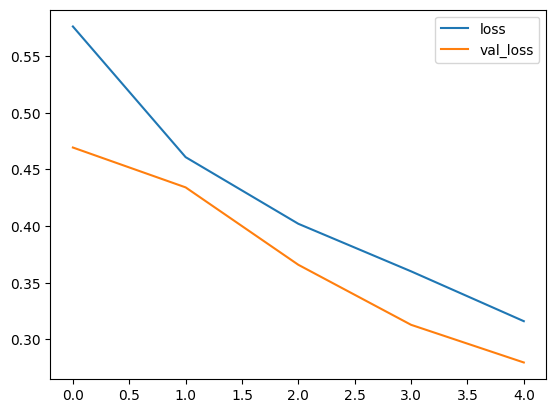

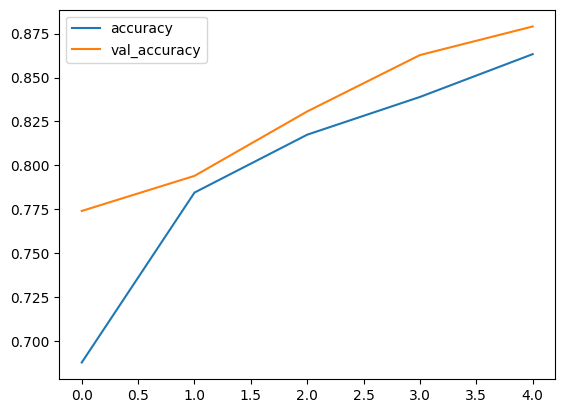

In [17]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [23]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Our Base Model Accuracy on Training Data: ", train_acc)
print("Our Base Model Accuracy on Validation Data: ", valid_acc)

212/212 [==============================] - 12s 56ms/step - loss: 0.2797 - accuracy: 0.8791
Our Base Model Accuracy on Training Data:  0.8782723546028137
Our Base Model Accuracy on Validation Data:  0.8790704607963562


***Data Augmentation on the fly***
1. A technique of artificially increasing the training set by creating modified copies of a dataset using existing data.
2. Increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation
3. Enlarge dataset
4. Avoid Overfitting

https://medium.com/@tagxdata/data-augmentation-for-computer-vision-9c9ed474291e

In [24]:
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1/255)
train_dir = 'data/cats-dogs/training/'
aug_train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
valid_dir = 'data/cats-dogs/validation/'
valid_generator = valid_datagen.flow_from_directory(valid_dir,target_size=(150, 150), batch_size=32,class_mode='binary')

Found 24982 images belonging to 2 classes.
Found 6756 images belonging to 2 classes.


**Augmented Model**

In [25]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('data/cats-dogs/weights.best.hdf5', monitor='val_loss', save_best_only=True)]


In [26]:
# create model
aug_model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(1, activation='sigmoid')
                       ])

# load weights if exists
if os.path.exists("data/cats-dogs/weights.best.hdf5"):
    aug_model.load_weights("weights.best.hdf5")

# Compile model 
aug_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
aug_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 128)      

In [27]:
aug_history = aug_model.fit(aug_train_generator, epochs=5, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/5
781/781 [==============================] - 239s 305ms/step - loss: 0.6200 - accuracy: 0.6447 - val_loss: 0.5303 - val_accuracy: 0.7359
Epoch 2/5
781/781 [==============================] - 237s 304ms/step - loss: 0.5118 - accuracy: 0.7473 - val_loss: 0.4780 - val_accuracy: 0.7774
Epoch 3/5
781/781 [==============================] - 236s 303ms/step - loss: 0.4553 - accuracy: 0.7864 - val_loss: 0.4213 - val_accuracy: 0.8025
Epoch 4/5
781/781 [==============================] - 238s 304ms/step - loss: 0.4007 - accuracy: 0.8199 - val_loss: 0.3619 - val_accuracy: 0.8397
Epoch 5/5
781/781 [==============================] - 241s 309ms/step - loss: 0.3598 - accuracy: 0.8408 - val_loss: 0.3809 - val_accuracy: 0.8218


<Axes: >

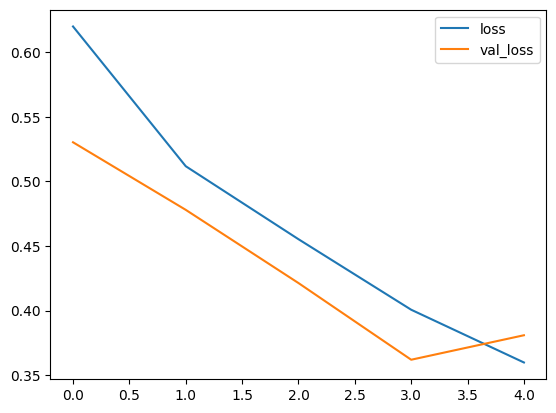

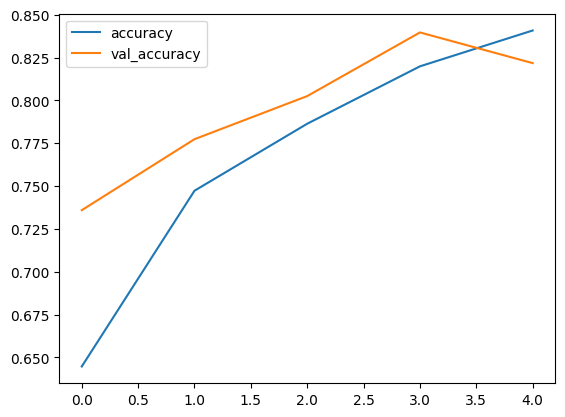

In [28]:
history_df = pd.DataFrame(aug_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [29]:
train_acc = aug_model.evaluate(train_generator)[1]
valid_acc = aug_model.evaluate(valid_generator)[1]
print("Our Augmented Base Model Accuracy on Training Data: ", train_acc)
print("Our Augmented Base Model Accuracy on Validation Data: ", valid_acc)

212/212 [==============================] - 12s 58ms/step - loss: 0.3809 - accuracy: 0.8218
Our Augmented Base Model Accuracy on Training Data:  0.818789541721344
Our Augmented Base Model Accuracy on Validation Data:  0.8217880129814148


**More Complex Model**
1. More Layers
2. Batch Normalization
3. Dropout

In [30]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('data/cats-dogs/weights2.best.hdf5', monitor='val_loss', save_best_only=True)]
# create model
new_model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
                            MaxPooling2D(2, 2),
                            Conv2D(64, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Conv2D(128, (3,3), activation='relu'),
                            MaxPooling2D(2,2),
                            Flatten(),
                            BatchNormalization(),
                            Dense(128, kernel_regularizer = L2(0.15), bias_regularizer=L2(0.15), activation='relu'),
                            Dropout(rate = 0.5 , seed = 40),
                            Dense(1, activation='sigmoid')  ])

# load weights if exists
if os.path.exists("data/cats-dogs/weights2.best.hdf5"):
    new_model.load_weights("weights2.best.hdf5")

# Compile model 
new_model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 17, 17, 128)      

In [31]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
781/781 [==============================] - 236s 301ms/step - loss: 1.4347 - accuracy: 0.7149 - val_loss: 1.0460 - val_accuracy: 0.5343
Epoch 2/20
781/781 [==============================] - 234s 300ms/step - loss: 0.5432 - accuracy: 0.7983 - val_loss: 0.5597 - val_accuracy: 0.7743
Epoch 3/20
781/781 [==============================] - 234s 299ms/step - loss: 0.4902 - accuracy: 0.8276 - val_loss: 0.9623 - val_accuracy: 0.6437
Epoch 4/20
781/781 [==============================] - 233s 299ms/step - loss: 0.4535 - accuracy: 0.8523 - val_loss: 0.4003 - val_accuracy: 0.8755
Epoch 5/20
781/781 [==============================] - 231s 296ms/step - loss: 0.4159 - accuracy: 0.8696 - val_loss: 0.4071 - val_accuracy: 0.8758
Epoch 6/20
781/781 [==============================] - 243s 311ms/step - loss: 0.3915 - accuracy: 0.8854 - val_loss: 0.3711 - val_accuracy: 0.8894
Epoch 7/20
781/781 [==============================] - 237s 303ms/step - loss: 0.3557 - accuracy: 0.8998 - val_loss: 0.3267 -

<Axes: >

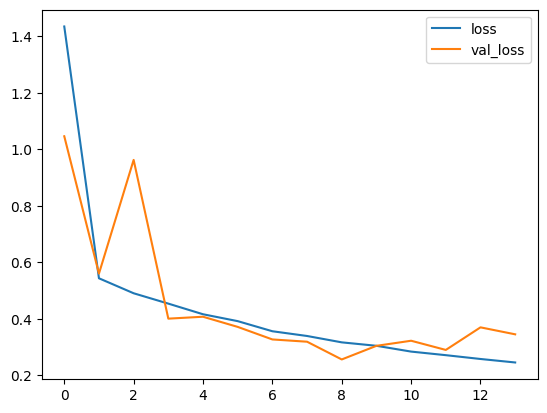

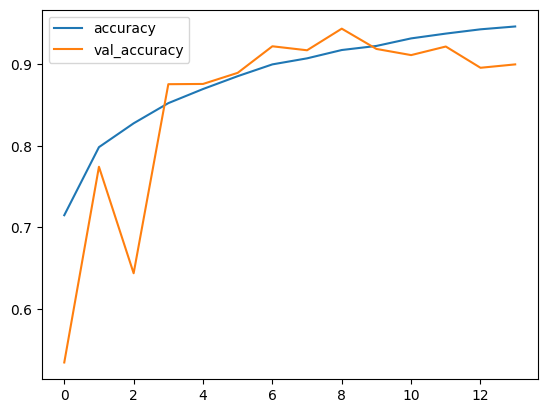

In [32]:
history_df = pd.DataFrame(new_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [33]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

212/212 [==============================] - 12s 57ms/step - loss: 0.3448 - accuracy: 0.8998
Our New Model Accuracy on Training Data:  0.901569128036499
Our New Model Accuracy on Validation Data:  0.8997927904129028


In [34]:
new_history = new_model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
781/781 [==============================] - 233s 298ms/step - loss: 0.2240 - accuracy: 0.9543 - val_loss: 0.2007 - val_accuracy: 0.9657
Epoch 2/20
781/781 [==============================] - 239s 306ms/step - loss: 0.2201 - accuracy: 0.9544 - val_loss: 0.1960 - val_accuracy: 0.9634
Epoch 3/20
781/781 [==============================] - 233s 298ms/step - loss: 0.2149 - accuracy: 0.9575 - val_loss: 0.2502 - val_accuracy: 0.9402
Epoch 4/20
781/781 [==============================] - 238s 305ms/step - loss: 0.2014 - accuracy: 0.9624 - val_loss: 0.1637 - val_accuracy: 0.9818
Epoch 5/20
781/781 [==============================] - 232s 298ms/step - loss: 0.1868 - accuracy: 0.9660 - val_loss: 0.1572 - val_accuracy: 0.9851
Epoch 6/20
781/781 [==============================] - 235s 301ms/step - loss: 0.1816 - accuracy: 0.9689 - val_loss: 0.1930 - val_accuracy: 0.9603
Epoch 7/20
781/781 [==============================] - 237s 303ms/step - loss: 0.1719 - accuracy: 0.9707 - val_loss: 0.1380 -

<Axes: >

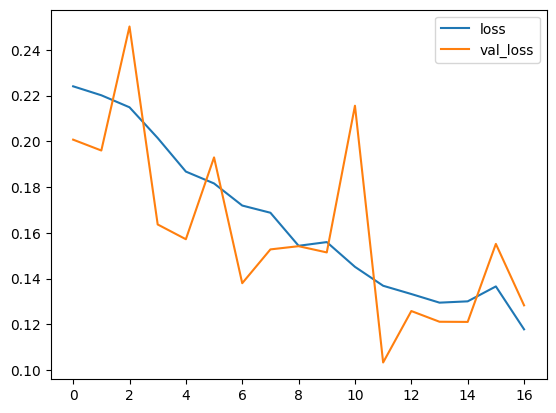

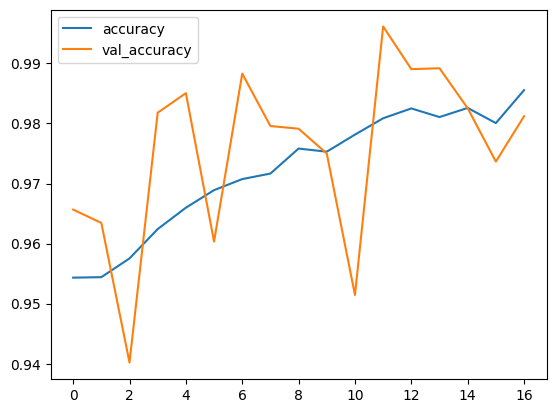

In [35]:
history_df = pd.DataFrame(new_history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [36]:
train_acc = new_model.evaluate(train_generator)[1]
valid_acc = new_model.evaluate(valid_generator)[1]
print("Our New Model Accuracy on Training Data: ", train_acc)
print("Our New Model Accuracy on Validation Data: ", valid_acc)

212/212 [==============================] - 14s 64ms/step - loss: 0.1283 - accuracy: 0.9812
Our New Model Accuracy on Training Data:  0.9799455404281616
Our New Model Accuracy on Validation Data:  0.9812018871307373


### Transfer Learning
1. A technique where knowledge learned from a task is re-used in order to boost performance on a related task.
2. The pre-trained models are usually trained on massive datasets that are a standard benchmark. The weights obtained from the models can be reused in other tasks.
3. Transfer learning is particularly very useful when you have a small training dataset.
How you can use pre-trained models
There are three ways to use a pre-trained model:

1. Prediction.
2. Feature Extraction.
3. Fine-tuning.

More About Pre-trained Models:
1. Keras Docs (https://keras.io/api/applications/)
2. Nice Article. (https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96)

In [37]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = 'data/cats-dogs/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [39]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 74, 74, 32)           96        ['conv2d_16[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [41]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [42]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)         

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 74, 74, 32)           96        ['conv2d_16[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization_1[0]

In [43]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [44]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('data/cats-dogs/weights_tf.best.hdf5', monitor='val_loss', save_best_only=True)]

# Train the model.
history = model.fit(aug_train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks = my_callbacks)

Epoch 1/20
781/781 [==============================] - 322s 411ms/step - loss: 0.1141 - accuracy: 0.9570 - val_loss: 0.0406 - val_accuracy: 0.9839
Epoch 2/20
781/781 [==============================] - 328s 420ms/step - loss: 0.0484 - accuracy: 0.9827 - val_loss: 0.0146 - val_accuracy: 0.9960
Epoch 3/20
781/781 [==============================] - 319s 409ms/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.0089 - val_accuracy: 0.9967
Epoch 4/20
781/781 [==============================] - 324s 415ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.0032 - val_accuracy: 0.9991
Epoch 5/20
781/781 [==============================] - 321s 411ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 6/20
781/781 [==============================] - 320s 410ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9996
Epoch 7/20
781/781 [==============================] - 311s 399ms/step - loss: 4.8446e-04 - accuracy: 0.9999 - val_loss: 0.00

212/212 [==============================] - 28s 133ms/step - loss: 0.0010 - accuracy: 0.9996
Transfer Learning Model Accuracy on Training Data:  0.9999599456787109
Transfer Learning Model Accuracy on Validation Data:  0.9995559453964233


<Axes: >

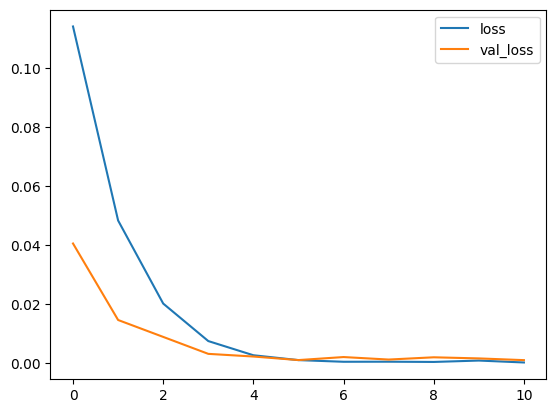

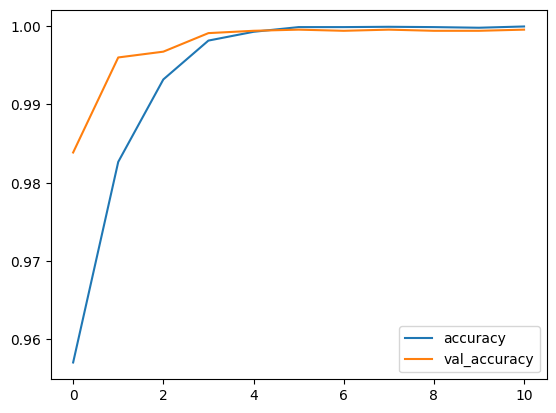

In [45]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Transfer Learning Model Accuracy on Training Data: ", train_acc)
print("Transfer Learning Model Accuracy on Validation Data: ", valid_acc)
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

In [46]:
model.save('data/cats-dogs/inception_model.keras')

### Predictions on Test Data

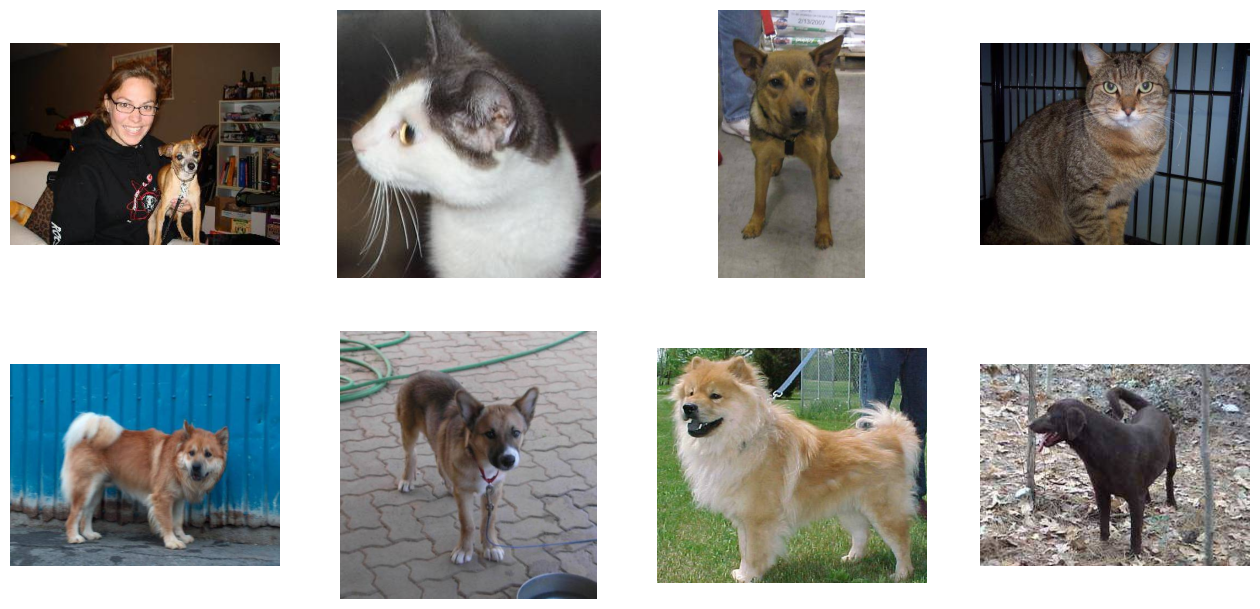

In [47]:
test_dir = 'data/cats-dogs/test1'
plt.figure(figsize=(16,16))
images = os.listdir(test_dir)
for i in range(8):
    img = random.choice([x for x in images])
    fig = plt.subplot(4,4,i+1)
    fig.axis('off')
    img = mpimg.imread(os.path.join(test_dir, img)) 
    fig.imshow(img)

### Preparing for Test Images

In [48]:
from tensorflow.keras.preprocessing import image
def convert_one_img(img_folder, img):
  # dimensions of image
    img_width, img_height = 150, 150
    img = os.path.join(img_folder, img)
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255
    return img

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('data/cats-dogs/inception_model.keras')

def predict_visualize_img(img_folder, img, model):
    img_fig = mpimg.imread(os.path.join(img_folder, img)) 
    plt.imshow(img_fig)
    
    img_prepared = convert_one_img(img_folder, img)
    pred = model.predict(img_prepared)[0][0]
    if pred <= 0.5:
        result = 'Predicted : Cat'
    else:
        result = 'Predicted : Dog'
    
    plt.title(result)
    return pred

In [1]:
predict_visualize_img(test_dir, os.listdir(test_dir)[10], model)

NameError: name 'predict_visualize_img' is not defined

In [2]:
def convert_imgs_to_tensors(img_folder):

  # load all images into a list
  images = []

  for img in os.listdir(img_folder):
    img = convert_one_img(img_folder, img)
    images.append(img)

  # stack up images list to pass for model
  images = np.vstack(images)

  return images

In [ ]:
test_images_prepared = convert_imgs_to_tensors(test_dir)

In [ ]:
test_data = os.listdir(test_dir)
test_df = pd.DataFrame({ "id" : test_data})
test_df['id'] = test_df['id'].str.split('.').str[0]
test_df['label'] = pred_test_images
test_df.head()

In [ ]:
test_df.to_csv('data/cats-dogs/my_first_preds.csv')